### Factores de aplicación de la generación programada respecto a la real

In [4]:
# Library import

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

In [5]:
s_path=Path.cwd()
s_prt_path=s_path.parent

objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI
df =objetoAPI.get_collections()   

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [2]:
FechaIni=dt.date(2023, 1, 1)
FechaFin=dt.date(2024, 12, 31)



In [3]:
df_Rec= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ListadoRecursos",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_Rec=df_Rec.drop('Date',axis=1)

In [5]:
df_Rec[(df_Rec.Values_CompanyCode=='CHVG')]

,Id,Values_Code,Values_Name,Values_Type,Values_Disp,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate,Values_State
20,Sistema,2SXQ,BIOENERGY,COGENERADOR,NO DESPACHADO CENTRALMENTE,COGENERADOR,CHVG,BAGAZO,2017-04-22,OPERACION
765,Sistema,APLU,FUTURA - APOTOLORRU,EOLICA,DESPACHADO CENTRALMENTE,NORMAL,CHVG,VIENTO,2022-12-01,PRUEBAS
777,Sistema,CELE,FUTURA - CASA ELECTRICA,EOLICA,DESPACHADO CENTRALMENTE,NORMAL,CHVG,VIENTO,2022-12-01,PRUEBAS
780,Sistema,CHVR,CHIVOR,HIDRAULICA,DESPACHADO CENTRALMENTE,NORMAL,CHVG,AGUA,1977-05-23,OPERACION
922,Sistema,TUJ1,TUNJITA,HIDRAULICA,NO DESPACHADO CENTRALMENTE,NORMAL,CHVG,AGUA,2016-06-30,OPERACION


In [4]:
# Unit kWh
df_GenPro= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "GeneProgDesp",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta

# df_GenPro.rename(columns={'Value':'VolUtil'},inplace=True)

In [7]:
# Unit kWh
df_GenReal= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "Gene",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta

In [8]:
# Generate a date range for one year (from January 1, 2023 to December 31, 2023)
date_range = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')

# Generate a range of values from 1 to 24 (for each hour or register)
registers = range(1, 25)

# Create a MultiIndex using the product of date_range and registers
multi_index = pd.MultiIndex.from_product([date_range, registers], names=['Date', 'Periodo'])

# Create the DataFrame
df_data = pd.DataFrame(index=multi_index)
df_data=df_data.reset_index()

df_GenPro1=df_GenPro.copy()
# df_GenPro1=df_GenPro1.fillna(0)
df_GenReal1=df_GenReal.copy()
# df_GenReal1=df_GenReal1.fillna(0)

l_per=[]

for i in range(1,25):

    l_per.append(i)

    if i<10:
        df_GenPro1=df_GenPro1.rename(columns={'Values_Hour0' + str(i):i})
        df_GenReal1=df_GenReal1.rename(columns={'Values_Hour0' + str(i):i})
    else:
        df_GenPro1=df_GenPro1.rename(columns={'Values_Hour' + str(i):i})
        df_GenReal1=df_GenReal1.rename(columns={'Values_Hour' + str(i):i})

df_GenPro1=df_GenPro1[(df_GenPro1['Values_code'].isin(['TBST']))]
df_GenPro1['Date']=pd.to_datetime(df_GenPro1['Date'])
df_GenReal1=df_GenReal1[(df_GenReal1['Values_code'].isin(['TBST']))]
df_GenReal1['Date']=pd.to_datetime(df_GenReal1['Date'])

df_GenPro1=df_GenPro1.drop(['Id'],axis=1)
df_GenReal1=df_GenReal1.drop(['Id'],axis=1)

df_GenPro1 = pd.melt(df_GenPro1, id_vars=['Date','Values_code'], var_name='Periodo', value_name='GenMW')
df_GenPro1['GenMW']=df_GenPro1['GenMW']/1000

df_GenReal1 = pd.melt(df_GenReal1, id_vars=['Date','Values_code'], var_name='Periodo', value_name='GenMWReal')
df_GenReal1['GenMWReal']=df_GenReal1['GenMWReal']/1000

# df_GenPro1=

df_data=df_data.merge(df_GenPro1,left_on=['Date','Periodo'],right_on=['Date','Periodo'], how='left')[['Date','Values_code','Periodo', 'GenMW']]
df_data['GenMW']=df_data['GenMW'].fillna(0)

df_data=df_data.merge(df_GenReal1,left_on=['Date','Values_code','Periodo'],right_on=['Date','Values_code','Periodo'], how='left')[['Date','Values_code','Periodo', 'GenMW', 'GenMWReal']]
df_data['GenMWReal']=df_data['GenMWReal'].fillna(0)

df_data['mes']=df_data['Date'].dt.month

df_data['dia']=df_data['Date'].dt.day

df_data=df_data.groupby(['mes','dia','Periodo'])[['GenMW', 'GenMWReal']].mean()
df_data=df_data.reset_index()

df_data.loc[df_data['GenMWReal'] <= 0, 'GenMWReal'] = 1
df_data.loc[df_data['GenMW'] <= 0, 'GenMW'] = df_data.loc[df_data['GenMW'] <= 0, 'GenMWReal'] 

df_data['Factor']=df_data['GenMWReal']/df_data['GenMW']

df_data.loc[df_data['Factor'] >2 , 'Factor'] = 2

df_data.loc[df_data['Factor'] <1 , 'Factor'] = 1

df_dataOri=df_data.copy()

df_data = df_data.pivot(index=['mes','dia'], columns='Periodo', values='Factor')

df_data=df_data.reset_index()

df_data

df_data.to_csv('Factores.csv')

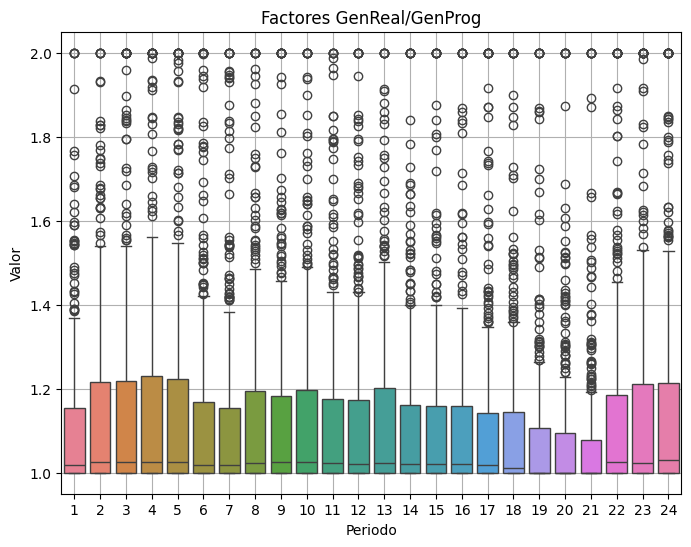

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for multiple columns
plt.figure(figsize=(8,6))
sns.boxplot(data=df_data[l_per])

plt.title('Factores GenReal/GenProg')
plt.xlabel('Periodo')
plt.ylabel('Valor')
plt.grid(True)

plt.show()


### Lectura de datos

In [10]:
# Lectura de datos de enrtrada para el cálculo
s_parentpath=Path('C:\Alejo\Eje de Planeación\Análisis Energético\Proyección2025')
filepath=s_parentpath.joinpath(s_parentpath,'gen_seg_TBST_2025_Mod_Factores.xlsx')

# Carga generación original
sheet_name='GenOriginal'
df_GenOri=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Carga generación original
sheet_name='GenModificada'
df_GenMod=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Carga generación original
sheet_name='GenOriginal2'
df_GenOri2=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
df_GenOri2['dia']=df_GenOri2['Fecha'].dt.day
df_GenOri2['mes']=df_GenOri2['Fecha'].dt.month

# Carga generación original Tebsa y Candelaria
sheet_name='GenOri_TBS_CAN'
df_GenOrTC_CD=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
df_GenOrTC_CD['dia']=df_GenOrTC_CD['Fecha'].dt.day
df_GenOrTC_CD['mes']=df_GenOrTC_CD['Fecha'].dt.month


### Aplicando el factor periodo a periodo

In [11]:
df_GenMod_per=df_GenOri2.merge(df_dataOri,left_on=['mes','dia','Periodo'],right_on=['mes','dia','Periodo'], how='left')[['Fecha','Periodo','mes','dia','TBST','Factor']]
df_GenMod_per['GenMWMod']=(df_GenMod_per['TBST']*df_GenMod_per['Factor']).clip(upper=791)

df_TotalMes=df_GenMod_per.groupby(['mes'])[['TBST','GenMWMod']].sum()
df_TotalMes['Porcentaje']=df_TotalMes['GenMWMod']/df_TotalMes['TBST']
df_TotalMes

,TBST,GenMWMod,Porcentaje
mes,,,
1,96200.00,113466.821406,1.179489
2,129904.00,137097.309513,1.055374
3,108360.00,117881.443197,1.087869
4,162296.34,168778.962040,1.039943
5,175859.71,210030.904793,1.194309
6,179520.26,203259.351597,1.132236
7,168221.58,198871.384228,1.182199
8,140771.00,160100.834415,1.137314
9,198828.85,206558.155115,1.038874


### Aplicando el percentil 75 de los periodos a cada periodo correspodiente

In [12]:
# Group by 'Category' and 'Subcategory' and calculate the 75th percentile
percentile_75 = df_dataOri.groupby(['Periodo'])[['Factor']].quantile(0.75)

df_GenMod_per=df_GenOri2.merge(percentile_75,left_on=['Periodo'],right_on=['Periodo'], how='left')[['Fecha','Periodo','mes','dia','TBST','Factor']]
df_GenMod_per['GenMWMod']=(df_GenMod_per['TBST']*df_GenMod_per['Factor']).clip(upper=791)

df_TotalMes=df_GenMod_per.groupby(['mes'])[['TBST','GenMWMod']].sum()
df_TotalMes['Porcentaje']=df_TotalMes['GenMWMod']/df_TotalMes['TBST']
df_TotalMes

,TBST,GenMWMod,Porcentaje
mes,,,
1,96200.00,112018.852170,1.164437
2,129904.00,151209.291545,1.164008
3,108360.00,126271.543103,1.165297
4,162296.34,189390.128133,1.166940
5,175859.71,204776.136356,1.164429
6,179520.26,209250.429826,1.165609
7,168221.58,196149.576656,1.166019
8,140771.00,164139.964356,1.166007
9,198828.85,231810.145469,1.165878


### Aplicando el percentil 75 de los meses a cada mes correspodiente

In [13]:
# Group by 'Category' and 'Subcategory' and calculate the 75th percentile
percentile_75 = df_dataOri.groupby(['mes'])[['Factor']].quantile(0.75)

df_GenMod_per=df_GenOri2.merge(percentile_75,left_on=['mes'],right_on=['mes'], how='left')[['Fecha','Periodo','mes','dia','TBST','Factor']]
df_GenMod_per['GenMWMod']=(df_GenMod_per['TBST']*df_GenMod_per['Factor']).clip(upper=791)

df_TotalMes=df_GenMod_per.groupby(['mes'])[['TBST','GenMWMod']].sum()
df_TotalMes['Porcentaje']=df_TotalMes['GenMWMod']/df_TotalMes['TBST']
df_TotalMes

,TBST,GenMWMod,Porcentaje
mes,,,
1,96200.00,120006.399027,1.247468
2,129904.00,131142.168604,1.009531
3,108360.00,125514.039282,1.158306
4,162296.34,162735.352787,1.002705
5,175859.71,227793.646007,1.295315
6,179520.26,215209.554960,1.198804
7,168221.58,208114.494431,1.237145
8,140771.00,172829.832767,1.227737
9,198828.85,207970.626264,1.045978


### Aplicando el percentil 75 de los meses a cada mes correspodiente de TEBSA y Termocandelaria

In [22]:
# Group by 'Category' and 'Subcategory' and calculate the 75th percentile
percentile_75 = df_dataOri.groupby(['mes'])[['Factor']].quantile(0.75)

df_GenMod_per=df_GenOrTC_CD.merge(percentile_75,left_on=['mes'],right_on=['mes'], how='left')[['Fecha','Periodo','mes','dia','TBST','TC','Factor']]
df_GenMod_per['GenMWModTBS']=(df_GenMod_per['TBST']*df_GenMod_per['Factor']).clip(upper=791).round(0)
df_GenMod_per['GenMWModTC']=(df_GenMod_per['TC']*df_GenMod_per['Factor']).clip(upper=555).round(0)

df_TotalMes=df_GenMod_per.groupby(['mes'])[['TBST','TC','GenMWModTBS','GenMWModTC']].sum()
df_TotalMes['PorcTBS']=df_TotalMes['GenMWModTBS']/df_TotalMes['TBST']
df_TotalMes['PorcTC']=df_TotalMes['GenMWModTC']/df_TotalMes['TC']
df_TotalMes

,TBST,TC,GenMWModTBS,GenMWModTC,PorcTBS,PorcTC
mes,,,,,,
2,16461.71,8721.47,16616.0,8803.0,1.009373,1.009348
3,126821.04,42217.81,146811.0,48783.0,1.157623,1.155508
4,134909.36,10968.15,135421.0,10971.0,1.003792,1.000260
5,166074.47,0.00,215132.0,0.0,1.295395,NaN
6,96734.84,56727.98,116034.0,67998.0,1.199506,1.198668
7,86954.74,64321.14,107554.0,79643.0,1.236896,1.238209
8,94154.73,28868.18,115542.0,35412.0,1.227150,1.226679
9,185187.66,0.00,193840.0,0.0,1.046722,NaN
10,192987.18,0.00,204171.0,0.0,1.057951,NaN


In [23]:
df_GenMod_per

,Fecha,Periodo,mes,dia,TBST,TC,Factor,GenMWModTBS,GenMWModTC
0,2025-02-27,1,2,27,437.0,330.00,1.009531,441.0,333.0
1,2025-02-27,2,2,27,234.0,342.47,1.009531,236.0,346.0
2,2025-02-27,3,2,27,234.0,330.00,1.009531,236.0,333.0
3,2025-02-27,4,2,27,210.0,330.00,1.009531,212.0,333.0
4,2025-02-27,5,2,27,210.0,176.00,1.009531,212.0,178.0
...,...,...,...,...,...,...,...,...,...
7387,2025-12-31,20,12,31,210.0,0.00,1.281273,269.0,0.0
7388,2025-12-31,21,12,31,234.0,0.00,1.281273,300.0,0.0
7389,2025-12-31,22,12,31,234.0,0.00,1.281273,300.0,0.0
7390,2025-12-31,23,12,31,234.0,0.00,1.281273,300.0,0.0


### Aplicando el percentil 75 del mes-periodo a cada mes-period correspodiente

In [16]:
# Group by 'Category' and 'Subcategory' and calculate the 75th percentile
percentile_75 = df_dataOri.groupby(['mes','Periodo'])[['Factor']].quantile(0.75)

df_GenMod_per=df_GenOri2.merge(percentile_75,left_on=['mes','Periodo'],right_on=['mes','Periodo'], how='left')[['Fecha','Periodo','mes','dia','TBST','Factor']]
df_GenMod_per['GenMWMod']=(df_GenMod_per['TBST']*df_GenMod_per['Factor']).clip(upper=791)

df_TotalMes=df_GenMod_per.groupby(['mes'])[['TBST','GenMWMod']].sum()
df_TotalMes['Porcentaje']=df_TotalMes['GenMWMod']/df_TotalMes['TBST']
df_TotalMes

,TBST,GenMWMod,Porcentaje
mes,,,
1,96200.00,119949.517822,1.246876
2,129904.00,133409.137641,1.026983
3,108360.00,120938.787781,1.116083
4,162296.34,163648.654107,1.008332
5,175859.71,229619.300810,1.305696
6,179520.26,210958.859869,1.175126
7,168221.58,207345.955387,1.232576
8,140771.00,168574.124717,1.197506
9,198828.85,207063.917724,1.041418


In [17]:
df_GenOriT=df_GenOri[df_GenOri.columns[:-1]]
df_GenOriT['dia']=df_GenOriT['FECHA'].dt.day
df_GenOriT['mes']=df_GenOriT['FECHA'].dt.month
df_GenOriT=pd.melt(df_GenOriT, id_vars=['FECHA','dia','mes'], var_name='Periodo', value_name='GenMWIni')
df_GenOriT['Periodo'] = df_GenOriT['Periodo'].astype(int)

df_GenModT=df_GenMod[df_GenMod.columns[:-1]]
df_GenModT['dia']=df_GenModT['FECHA'].dt.day
df_GenModT['mes']=df_GenModT['FECHA'].dt.month
df_GenModT=pd.melt(df_GenModT, id_vars=['FECHA','dia','mes'], var_name='Periodo', value_name='GenMWMod')
df_GenModT['Periodo'] = df_GenModT['Periodo'].astype(int)

df_dataGen=df_GenOriT.merge(df_GenModT,left_on=['FECHA','mes','dia','Periodo'],right_on=['FECHA','mes','dia','Periodo'], how='left')[['FECHA','mes','dia','Periodo', 'GenMWIni','GenMWMod']]
df_dataGen


,FECHA,mes,dia,Periodo,GenMWIni,GenMWMod
0,2025-01-01,1,1,1,210.0,210.000000
1,2025-01-02,1,2,1,0.0,0.000000
2,2025-01-03,1,3,1,210.0,217.431400
3,2025-01-04,1,4,1,0.0,0.000000
4,2025-01-05,1,5,1,0.0,0.000000
...,...,...,...,...,...,...
8755,2025-12-27,12,27,24,210.0,214.446801
8756,2025-12-28,12,28,24,210.0,218.361892
8757,2025-12-29,12,29,24,210.0,420.000000
8758,2025-12-30,12,30,24,210.0,214.483922


In [18]:
df_Total=pd.DataFrame(df_dataGen[['GenMWIni','GenMWMod']].sum())
df_TotalPor=df_Total.loc['GenMWMod',0]/df_Total.loc['GenMWIni',0]
df_TotalPor

1.107550749035244

In [19]:
df_TotalMes=df_dataGen.groupby(['mes'])[['GenMWIni','GenMWMod']].sum()
df_TotalMes['Porcentaje']=df_TotalMes['GenMWMod']/df_TotalMes['GenMWIni']
df_TotalMes

,GenMWIni,GenMWMod,Porcentaje
mes,,,
1,96200.00,113466.821406,1.179489
2,129904.00,137097.309513,1.055374
3,108360.00,117881.443197,1.087869
4,162296.34,168778.962040,1.039943
5,175859.71,210030.904793,1.194309
6,179520.26,203259.351597,1.132236
7,168221.58,198871.384228,1.182199
8,140771.00,160100.834415,1.137314
9,198828.85,206558.155115,1.038874


In [20]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import datetime as dt
import pandas as pd
import holidays

co_holidays = holidays.Colombia()

delta=dt.timedelta(days=1)

# Get all holidays for a specific year (e.g., 2025)
s_FechaIni='2025-01-01'
s_FechaFin='2025-12-31'

#Camniar a formato fecha
d_FechaIni=dt.datetime.strptime(s_FechaIni,'%Y-%m-%d')
d_FechaFin=dt.datetime.strptime(s_FechaFin,'%Y-%m-%d')


fecha=d_FechaIni

l_fecha=[]
while fecha<=d_FechaFin:

    if fecha in co_holidays:
        l_fecha.append(fecha)

    fecha=fecha+delta

df_fecha=pd.DataFrame(l_fecha,columns=['Fecha'])


In [21]:
df_fecha

,Fecha
0,2025-01-01
1,2025-01-06
2,2025-03-24
3,2025-04-17
4,2025-04-18
5,2025-05-01
6,2025-06-02
7,2025-06-23
8,2025-06-30
9,2025-07-20
